In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [85]:
# x = [p,v,b_a]
# u = [a]
# y = [p]

A = [[0, 1, 0],
     [0, 0, -1],
     [0, 0, 0]]
B = [[0],
     [1],
     [0]]
C = [[1, 0, 0]]
D = [[0]]

sys = ct.ss(A, B, C, D)
obs = ct.obsv(sys.A, sys.C)
print("Obs: ", np.linalg.matrix_rank(obs))

# generate trajectory p(t)
end = 60
samples = end*200
t = np.linspace(0, end, samples)
p = np.sin(t)
v = np.cos(t)
a_bias = 0.1
a_noise = np.random.randn(samples)
a = -np.sin(t) + a_bias + a_noise
yp = p + 0.1*np.random.randn(samples)
# yp = np.vstack([yp, v + 0.05*np.random.randn(samples)])

comb = np.concatenate([A, B], axis=1)
comb = np.concatenate([comb, np.zeros((1, 4))], axis=0)

dt = t[1] - t[0]
print(dt)
la.expm(comb*dt)
Ad = la.expm(comb*dt)[:3, :3]
Bd = la.expm(comb*dt)[:3, 3:]
Ad, Bd

Obs:  3
0.005000416701391783


(array([[ 1.00000000e+00,  5.00041670e-03, -1.25020836e-05],
        [ 0.00000000e+00,  1.00000000e+00, -5.00041670e-03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[1.25020836e-05],
        [5.00041670e-03],
        [0.00000000e+00]]))

60.00500041670139

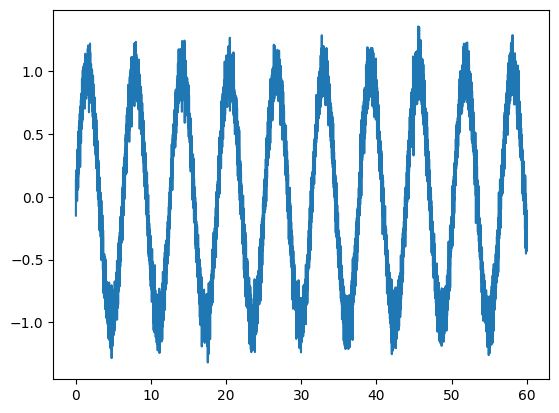

In [95]:
plt.plot(t, yp)
samples * dt

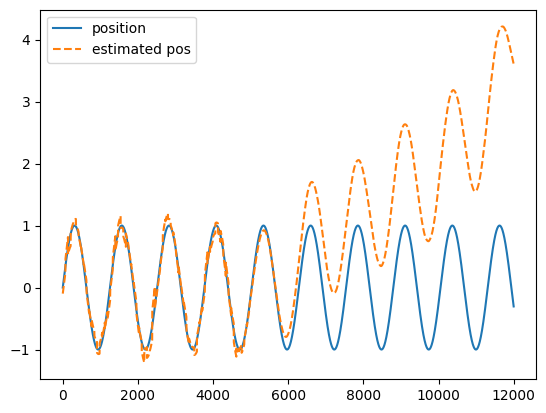

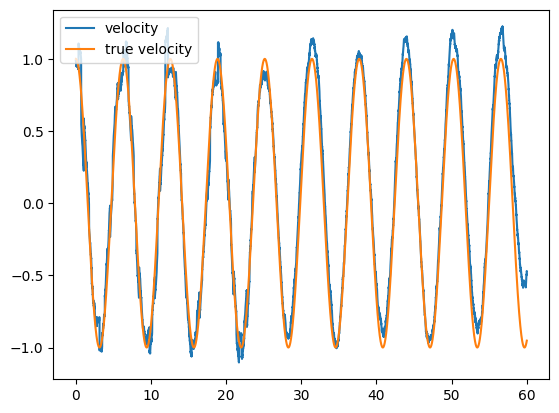

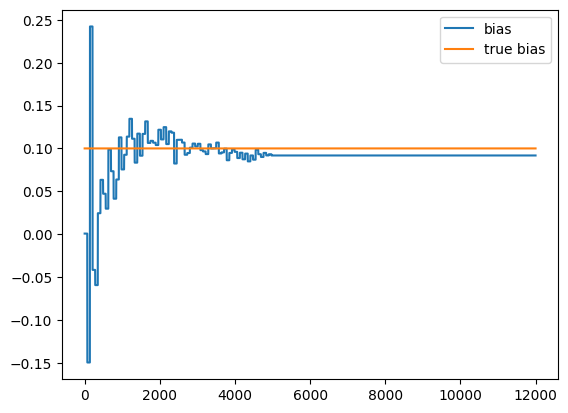

In [97]:
# Define the system matrices
F = Ad

H = np.array(C)

# Process noise covariance
Q = np.diag([1, 1, 0])

# Measurement noise covariance
R = np.diag([[1]])

# Initial state estimate
x_hat = np.array([[0], [1], [0]])

# Initial error covariance
P = np.diag([1, 100, 1000])

record = np.zeros((len(p), 3))

pos_modulo = int(np.ceil(0.033/dt)) * 10

# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat + Bd * a[i]
    P = F @ P @ F.T + Q

    # Update step
    if i % pos_modulo == 0 and i < 5000:
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        x_hat = x_hat + K @ (yp[i] - H @ x_hat)
        P = (np.eye(3) - K @ H) @ P

    record[i, :] = x_hat.T

# plt.figure(dpi=200)
plt.plot(t,p, label='position')
plt.plot(t,record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(t, record[:, 1], label='velocity')
plt.plot(t, v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(record[:, 2], label='bias')
plt.plot(np.ones(len(record))*a_bias, label='true bias')
plt.legend()

Obs:  4


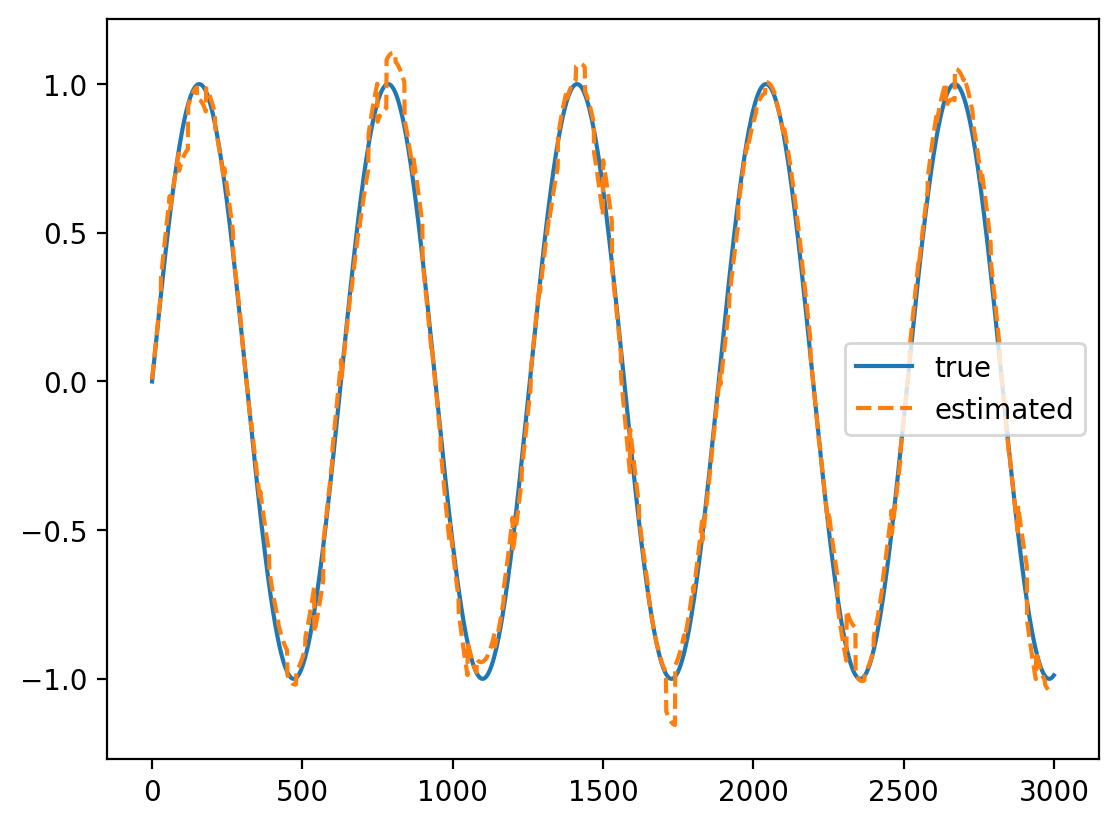

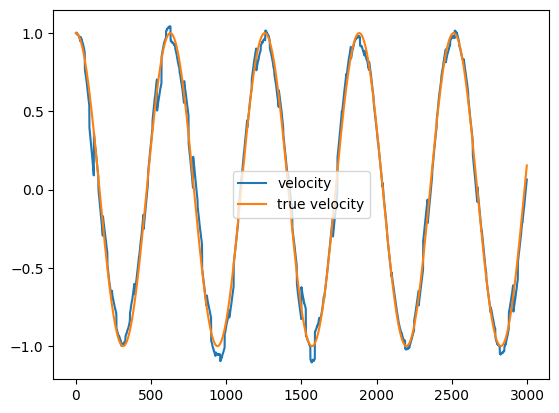

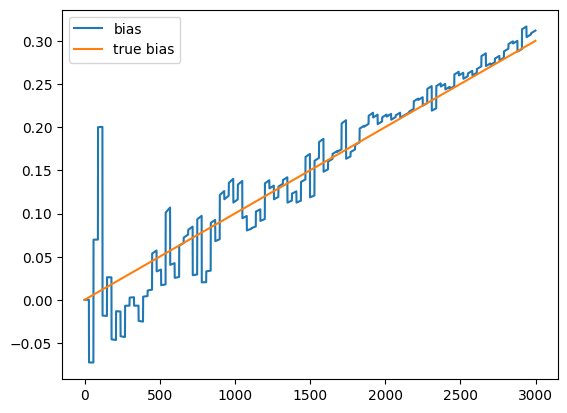

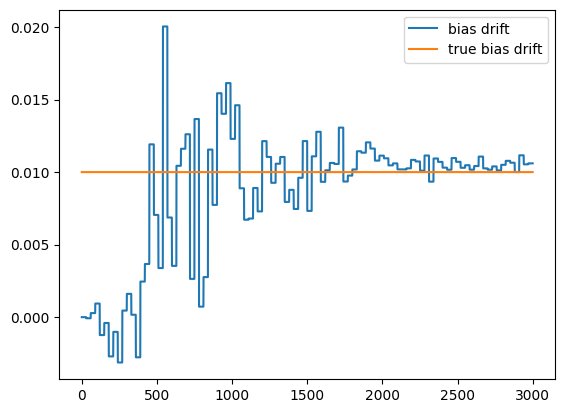

In [7]:
# x = [p,v,b_a,b_a_dot]
# u = [a]
# y = [p]

A = [[0, 1, 0, 0],
     [0, 0, -1, 0],
     [0, 0, 0, 1],
     [0, 0, 0, 0]]
B = [[0],
     [1],
     [0],
     [0]]
C = [[1, 0, 0, 0]]
D = [[0]]
n = 4
dt = 0.01

sys = ct.ss(A, B, C, D)
obs = ct.obsv(sys.A, sys.C)
print("Obs: ", np.linalg.matrix_rank(obs))

# generate trajectory p(t)
end = 30
samples = end*100
p = np.sin(np.linspace(0, end, samples))
v = np.cos(np.linspace(0, end, samples))
# generate slowly varying bias, basically a line with a slope
a_bias = np.linspace(0, .3, samples)
slope = (a_bias[2] - a_bias[1]) / dt
# a_bias = 0.1*np.sin(np.linspace(0, end, samples)) + 0.3
# a_bias_dot = 0.1*np.cos(np.linspace(0, end, samples))
a_noise = 0.2*np.random.randn(samples)
a = -np.sin(np.linspace(0, end, samples)) + a_bias + a_noise
yp = p + 0.05*np.random.randn(samples)

comb = np.concatenate([A, B], axis=1)
comb = np.concatenate([comb, np.zeros((1, comb.shape[1]))], axis=0)

la.expm(comb*dt)
Ad = la.expm(comb*dt)[:n, :n]
Bd = la.expm(comb*dt)[:n, n:]

# Define the system matrices
F = Ad

H = np.array(C)

# Process noise covariance
Q = np.diag([1, 1, 0, 0])

# Measurement noise covariance
R = np.array([[0.05]])

# Initial state estimate
x_hat = np.array([[0], [1.0], [0], [0]])

# Initial error covariance
P = np.diag([1, 1, 1000, 10])

record = np.zeros((len(p), n))

# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat + Bd * a[i]
    P = F @ P @ F.T + Q

    # Update step
    if i % end == 0:
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        x_hat = x_hat + K @ (yp[i] - H @ x_hat)
        P = (np.eye(n) - K @ H) @ P

#     print("Estimated position:", x_hat[0, 0])
#     print("Estimated velocity:", x_hat[1, 0])
#     print("Estimated bias:", x_hat[2, 0])
#     print("Estimated bias drift:", x_hat[3, 0])
#     print("p error:", np.abs(x_hat[0, 0] - p[i]))

    record[i, :] = x_hat.T
#     print()

plt.figure(dpi=200)
plt.plot(p, label='true')
plt.plot(record[:, 0], label='estimated', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(record[:, 1], label='velocity')
plt.plot(v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(record[:, 2], label='bias')
plt.plot(np.ones(len(record))*a_bias, label='true bias')
plt.legend()
plt.figure()
plt.plot(record[:, 3], label='bias drift')
plt.plot(np.ones(samples)*slope, label='true bias drift')
plt.legend()